In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [14]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (128, 128)
DATA_DIR = "Dataset/preprocessed_images"
META_CSV = "Dataset/meta_train.csv"
EPOCHS = 30
BATCH_SIZE = 32

In [15]:
meta_df = pd.read_csv(META_CSV)
label_map = {label: idx for idx, label in enumerate(meta_df["label"].unique())}
meta_df["label_encoded"] = meta_df["label"].map(label_map)
meta_df["variety_encoded"] = pd.factorize(meta_df["variety"])[0]
num_classes = len(meta_df["variety_encoded"].unique())
CLASS_NAMES = meta_df["variety"].unique()

In [ ]:
X, y = [], []

for _, row in meta_df.iterrows():
    img_id = row["image_id"].replace(".jpg", "")
    try:
        red = (
            img_to_array(
                load_img(
                    os.path.join(DATA_DIR, row["label"], img_id + "_red.jpg"),
                    target_size=IMG_SIZE,
                )
            )
            / 255.0
        )
        green = (
            img_to_array(
                load_img(
                    os.path.join(DATA_DIR, row["label"], img_id + "_green.jpg"),
                    target_size=IMG_SIZE,
                )
            )
            / 255.0
        )
        blue = (
            img_to_array(
                load_img(
                    os.path.join(DATA_DIR, row["label"], img_id + "_blue.jpg"),
                    target_size=IMG_SIZE,
                )
            )
            / 255.0
        )
        spectral = (
            img_to_array(
                load_img(
                    os.path.join(DATA_DIR, row["label"], img_id + "_nipy_spectral.jpg"),
                    target_size=IMG_SIZE,
                    color_mode="grayscale",
                )
            )
            / 255.0
        )
        spectral = np.repeat(spectral, 3, axis=-1)
        img_array = np.concatenate([red, green, blue, spectral], axis=-1)
        X.append(img_array)
        y.append(row["variety_encoded"])
    except FileNotFoundError:
        continue

X = np.array(X)
y = to_categorical(y, num_classes=num_classes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [ ]:
model = Sequential(
    [
        Conv2D(
            32, (3, 3), activation="relu", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 12)
        ),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      3488      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)     

In [ ]:
# 1. Create the datagen generator
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
)

# 2. Fit the model using the generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
)

c:\Users\Administrator\anaconda3\envs\myenv\lib\site-packages\keras\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8325, 128, 128, 12) (12 channels).
  warnings.warn(


Epoch 1/30
261/261 [==============================] - 134s 512ms/step - loss: 1.1935 - accuracy: 0.6810 - val_loss: 1.1726 - val_accuracy: 0.6950
Epoch 2/30
261/261 [==============================] - 96s 368ms/step - loss: 0.9650 - accuracy: 0.7074 - val_loss: 0.9244 - val_accuracy: 0.7209
Epoch 3/30
261/261 [==============================] - 99s 379ms/step - loss: 0.7968 - accuracy: 0.7417 - val_loss: 0.7166 - val_accuracy: 0.7704
Epoch 4/30
261/261 [==============================] - 100s 383ms/step - loss: 0.6587 - accuracy: 0.7815 - val_loss: 0.6602 - val_accuracy: 0.7848
Epoch 5/30
261/261 [==============================] - 105s 401ms/step - loss: 0.5667 - accuracy: 0.8067 - val_loss: 0.5527 - val_accuracy: 0.8165
Epoch 6/30
261/261 [==============================] - 105s 401ms/step - loss: 0.4777 - accuracy: 0.8384 - val_loss: 0.4602 - val_accuracy: 0.8516
Epoch 7/30
261/261 [==============================] - 107s 410ms/step - loss: 0.4072 - accuracy: 0.8586 - val_loss: 0.3348 - v

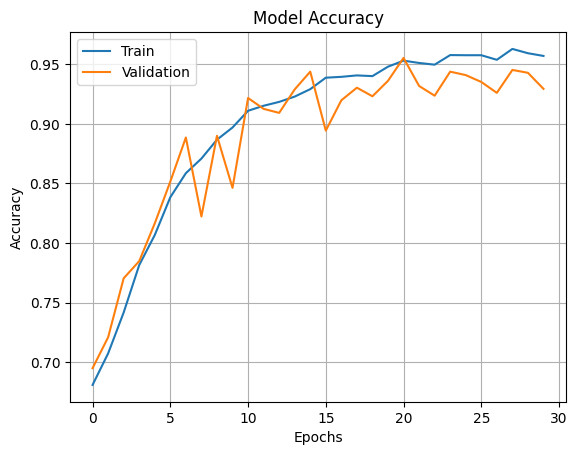

In [ ]:
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
IMAGE_DIR = "Dataset/preprocessed_test_images"


def predict_variety(image_id):
    try:
        red = (
            img_to_array(
                load_img(f"{IMAGE_DIR}/{image_id}_red.jpg", target_size=IMG_SIZE)
            )
            / 255.0
        )
        green = (
            img_to_array(
                load_img(f"{IMAGE_DIR}/{image_id}_green.jpg", target_size=IMG_SIZE)
            )
            / 255.0
        )
        blue = (
            img_to_array(
                load_img(f"{IMAGE_DIR}/{image_id}_blue.jpg", target_size=IMG_SIZE)
            )
            / 255.0
        )
        spectral = (
            img_to_array(
                load_img(
                    f"{IMAGE_DIR}/{image_id}_nipy_spectral.jpg",
                    target_size=IMG_SIZE,
                    color_mode="grayscale",
                )
            )
            / 255.0
        )
        spectral = np.repeat(spectral, 3, axis=-1)  # Convert grayscale to 3 channels

        # Stack into (128, 128, 12)
        img_array = np.concatenate([red, green, blue, spectral], axis=-1)
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_variety = CLASS_NAMES[predicted_index]
        return predicted_variety
    except Exception as e:
        print(f"Skipping {image_id}: {e}")
        return None


# Collect predictions
all_files = os.listdir(IMAGE_DIR)
image_ids = sorted(set(f.split("_")[0] for f in all_files if f.endswith(".jpg")))

results = []
for image_id in image_ids:
    variety = predict_variety(image_id)
    if variety:
        results.append({"image_id": f"{image_id}.jpg", "variety": variety})

df = pd.DataFrame(results)
df.to_csv("task2_predictions.csv", index=False)
print("Saved predictions to task2_predictions.csv")

Saved predictions to task2_predictions.csv


In [22]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on test set:", acc)

66/66 [==============================] - 1s 10ms/step
Accuracy on test set: 0.9293948126801153


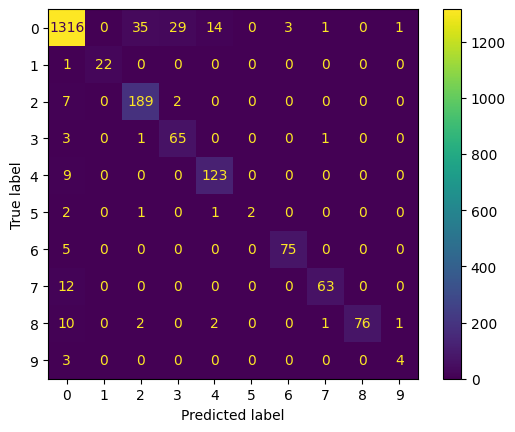

In [23]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
ConfusionMatrixDisplay(cm).plot()

In [24]:
print(classification_report(y_true_labels, y_pred_labels, target_names=CLASS_NAMES))

                precision    recall  f1-score   support

         ADT45       0.96      0.94      0.95      1399
          IR20       1.00      0.96      0.98        23
KarnatakaPonni       0.83      0.95      0.89       198
      Onthanel       0.68      0.93      0.78        70
         Ponni       0.88      0.93      0.90       132
         Surya       1.00      0.33      0.50         6
         Zonal       0.96      0.94      0.95        80
    AndraPonni       0.95      0.84      0.89        75
  AtchayaPonni       1.00      0.83      0.90        92
            RR       0.67      0.57      0.62         7

      accuracy                           0.93      2082
     macro avg       0.89      0.82      0.84      2082
  weighted avg       0.94      0.93      0.93      2082



In [ ]:
model.save("task2_4_colors.keras")